In [1]:
# !pip install -e /user/rea3/AP-ReA/jupyter-ML/pkgs/objFuncs
# !pip install -e /user/rea3/AP-ReA/jupyter-ML/pkgs/pyBO

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
from phantasy import caget

In [3]:
import objFuncs
from objFuncs import residuals
from objFuncs.util import plot_obj_history

[17:03:38.416] INFO: phantasy.library.operation.core: Load new machine: 'FRIB', segment: 'LINAC'
[17:03:38.418] INFO: phantasy.library.parser.config: Importing FRIB from /projects/rea3/data/CrispAnalysis/phantasy-machines/FRIB
[17:03:38.419] INFO: phantasy.library.parser.config: Loading machine configuration from /projects/rea3/data/CrispAnalysis/phantasy-machines/FRIB/phantasy.ini
[17:03:38.420] INFO: phantasy.library.operation.lattice: Loading segment: 'LINAC'
[17:03:38.452] ERROR: phantasy.library.operation.core: Cannot load machine: FRIB segment: LINAC


   _test : False
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 2.05
   _return_obj_var : False
   _check_chopper_blocking : False


In [4]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = 2.05
objFuncs._global_machineIO._ensure_set_timewait_after_ramp : 0.25
# objFuncs._global_machineIO.view()

   _test : True
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 2.05
   _return_obj_var : False
   _check_chopper_blocking : False
   _n_popup_ramping_not_OK : 0


In [5]:
ion = caget("REA_EXP:ELMT")
Q = int(caget("REA_EXP:Q"))
A = int(caget("REA_EXP:A"))
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print(ion, 'A/Q=',AQ)

20Ne8 A/Q= 2.5


In [ ]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

In [6]:
now0 = datetime.datetime.now()
now0str = now0.strftime('%Y%m%d_%H%M')
fname = now0str+'['+ion+']'+nb_name.strip('.ipynb')
fname

'[REA][LSQ]20231208_1703_20Ne8_Qcentering'

# Decision parameters and range

In [8]:
decision_CSETs = ['REA_BTS31:DCH_D1393:I_CSET',
                  'REA_BTS31:DCV_D1393:I_CSET',
                  'REA_BTS31:DCH_D1423:I_CSET',
                  'REA_BTS31:DCV_D1423:I_CSET',
                  ]
decision_min = [-15*AQ,-135*AQ,-135*AQ,-135*AQ]
decision_max = [ 15*AQ, 135*AQ, 135*AQ, 135*AQ]
print(decision_min)
print(decision_max)

# Conditions over which the variation of objective will be minimized

##### example:
The following:

    conditional_SETs = {
        'Q1:I_CSET':[100,120,100],
        'Q2:I_CSET':[100,100,120],
    }
    
means that we will evaluate objectives, (at given decision parameters, x) at 3 different conditions:

    Obj1(x) at Q1,Q2=(100,100),
    Obj2(x) at Q1,Q2=(120,100), 
    Obj3(x) at Q1,Q2=(100,120),
    
Then find root of "Obj2(x)-Obj1(x)" and "Obj3(x)-Obj1(x)" by deciding the decision paratemers under linear response assumption. In other words, we minimize variation of objectives over different conditions.

In [9]:
conditional_SETs = {
    'REA_BTS31:Q_D1431:I_CSET':[100,120,100],
    'REA_BTS31:Q_D1435:I_CSET':[100,100,120],
}

n_condition = None
for k,v in conditional_SETs.items():
    if not n_condition:
        n_condition = len(v) 
    else:
        assert len(v) == n_condition

In [11]:
#  the values objective_goal is not meaningful unless "var_obj_weight_fraction < 1" 
#  "var_obj_weight_fraction" is used in the "residualObjMultiConditionalVar" class instantiation
#  "var_obj_weight_fraction = 1" will optimize only the variation of objective values over different conditions
objective_goal = { 
        'SOMEWHERE:VIWER:XPOS_RD' : 0.0,     
        'SOMEWHERE:VIWER:YPOS_RD' : 0.0, 
        }
#  objective_norm and objective_weight is important as they define the relative importance of each objective
objective_norm = { 
        'SOMEWHERE:VIWER:XPOS_RD' : 1.0,     #(mm)
        'SOMEWHERE:VIWER:YPOS_RD' : 1.0,  
        }
objective_weight = { 
        'SOMEWHERE:VIWER:XPOS_RD' : 1.0,     #(mm)
        'SOMEWHERE:VIWER:YPOS_RD' : 1.0,  
        }

In [12]:
res = residuals.residualObjMultiConditionalVar(  
    decision_CSETs = decision_CSETs,
    decision_min   = decision_min,
    decision_max   = decision_max,
    objective_goal = objective_goal,
    objective_norm = objective_norm,
    objective_weight = objective_weight,
    conditional_SETs = conditional_SETs,
    var_obj_weight_fraction = 1,
    )

======== class info ========
init_time: 2023-12-08 17:03:41.654789
class_hierarchy: [
    objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f63e60b2d00>
decision_CSETs: [
    REA_BTS30:PSQ_D1221:I_CSET, REA_BTS30:PSQ_D1228:I_CSET]
decision_min: [100. 100.]
decision_max: [120. 120.]
decision_bounds: [[100 120]
 [100 120]]
decision_RDs: [
    REA_BTS30:PSQ_D1221:I_RD, REA_BTS30:PSQ_D1228:I_RD]
decision_tols: [1. 2.]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: condition_controler
logging_fname: None
x0: [ 50.50365558 -50.61015153]

self._objective_weight_arr [1. 1.]
self._objective_weight_arr.mean() 1.0
======== class info ========
init_time: 2023-12-08 17:03:50.011674
class_hierarchy: [
    residualObj, objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f63e60b2ee0>
decision_CSETs: [
    REA_BTS25:PSC2_D1172:I_CSET, REA_BTS25:PSC1_D1172:I_CSET, REA_BTS30:PSC2_D1219:I_CSET
 

In [13]:
plot_decision = plot_obj_history(
            res.history['decision_CSETs'],
            )
plot_RDs = plot_obj_history(
            res.history['condition0']['objective_RDs'],
            )
plot_objs = plot_obj_history(
            res.history['condition0']['objectives'],
            )
callbacks = [plot_decision,plot_RDs,plot_objs]

In [14]:
# this will allow manual input of Viewer reading
_manual_fetcher = objFuncs.construct_machineIO.construct_manual_fetch_data(objective_goal.keys())
objFuncs._global_machineIO.fetch_data = _manual_fetcher

# Run optimization
except: n_read = (n_decision+2) $\times$ n_condition

In [28]:
print( (len(decision_CSETs)+2)*n_condition )

NameError: name 'n_condition' is not defined

=== Manual Input. Leave blank for automatic data read. ===
SOMEWHERE:VIWER:XPOS_RD: n
Input not accepatble format
trying caget SOMEWHERE:VIWER:XPOS_RD...
cannot connect to SOMEWHERE:VIWER:XPOS_RD
SOMEWHERE:VIWER:XPOS_RD: f
Input not accepatble format
SOMEWHERE:VIWER:XPOS_RD: f
Input not accepatble format
SOMEWHERE:VIWER:XPOS_RD: g
Input not accepatble format
SOMEWHERE:VIWER:XPOS_RD: j
Input not accepatble format
SOMEWHERE:VIWER:XPOS_RD: 8
SOMEWHERE:VIWER:YPOS_RD: sdf
Input not accepatble format
trying caget SOMEWHERE:VIWER:YPOS_RD...
cannot connect to SOMEWHERE:VIWER:YPOS_RD
SOMEWHERE:VIWER:YPOS_RD: 0
=== Manual Input. Leave blank for automatic data read. ===
SOMEWHERE:VIWER:XPOS_RD: 0
SOMEWHERE:VIWER:YPOS_RD: 0
=== Manual Input. Leave blank for automatic data read. ===
SOMEWHERE:VIWER:XPOS_RD: 0
SOMEWHERE:VIWER:YPOS_RD: 0
=== Manual Input. Leave blank for automatic data read. ===
SOMEWHERE:VIWER:XPOS_RD: 0
SOMEWHERE:VIWER:YPOS_RD: 0
=== Manual Input. Leave blank for automatic data rea

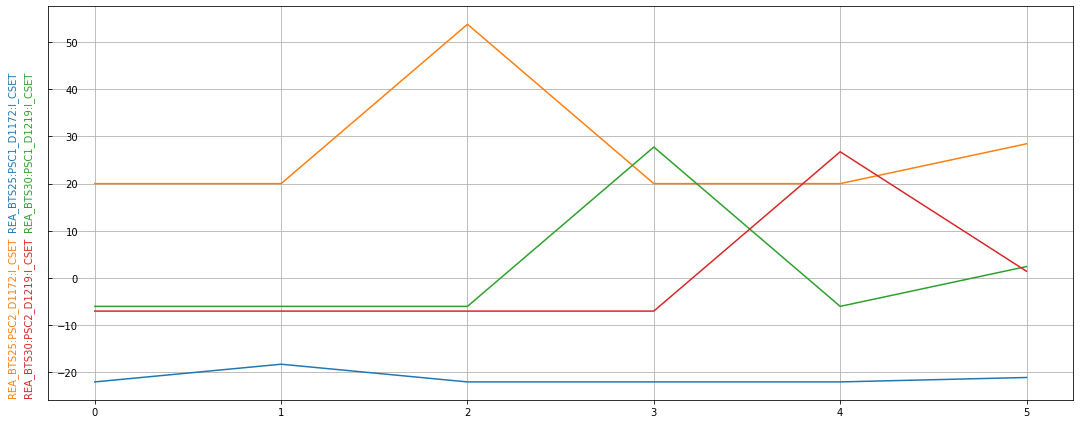

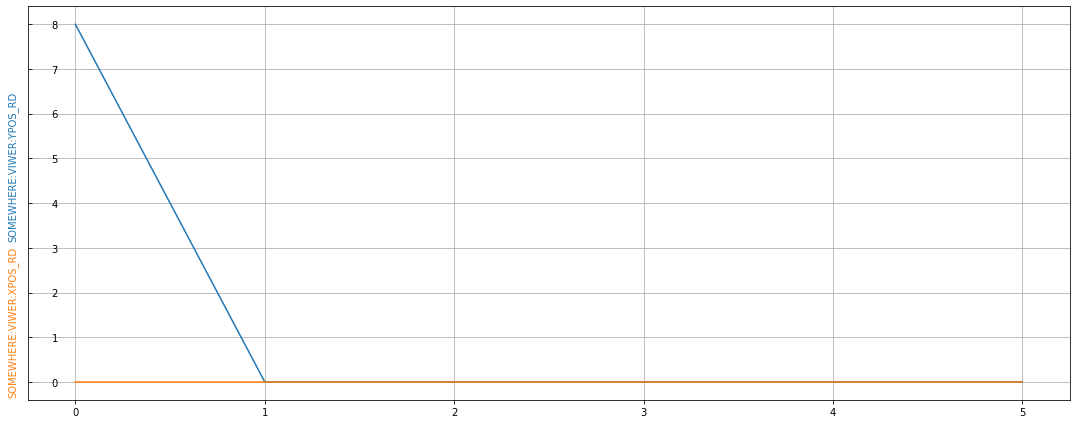

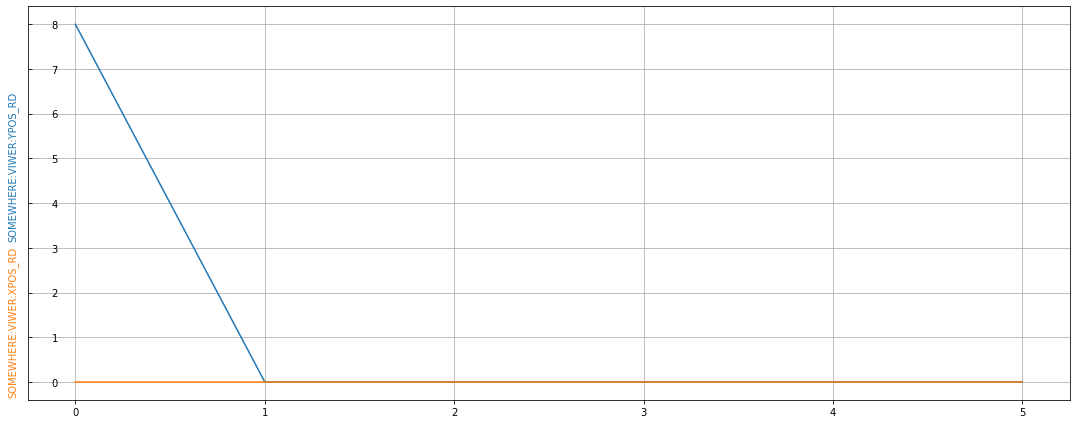

In [15]:
# Whenver prompt is active, just read and type in
result = res.lsq_linear(jac_use3points=False,callbacks=callbacks)
for f in callbacks:
    f.close()

In [31]:
print("== Final decisions ==")
for pv,x in zip(decision_CSETs,result.x):
    print(" ",pv,x)

== Final decision ==
  REA_BTS25:PSC2_D1172:I_CSET -21.0625
  REA_BTS25:PSC1_D1172:I_CSET 28.4375
  REA_BTS30:PSC2_D1219:I_CSET 2.4375
  REA_BTS30:PSC1_D1219:I_CSET 1.4375


In [17]:
res.history['objectives_var']["values"]

[array([-8.,  0., -8.,  0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.])]

In [18]:
res.history['objectives_var']['names']

['D10_SOMEWHERE:VIWER:XPOS_RD',
 'D10_SOMEWHERE:VIWER:YPOS_RD',
 'D20_SOMEWHERE:VIWER:XPOS_RD',
 'D20_SOMEWHERE:VIWER:YPOS_RD']

In [19]:
for n,v in zip(res.history['jacobian_var']['names'], res.history['jacobian_var']['values'][0]):
    print(n,v)

d (D10 SOMEWHERE:VIWER:XPOS_RD)/d REA_BTS25:PSC2_D1172:I_CSET 2.1333333333333306
d (D10 SOMEWHERE:VIWER:XPOS_RD)/d REA_BTS25:PSC1_D1172:I_CSET 0.23703703703703674
d (D10 SOMEWHERE:VIWER:XPOS_RD)/d REA_BTS30:PSC2_D1219:I_CSET 0.23703703703703674
d (D10 SOMEWHERE:VIWER:XPOS_RD)/d REA_BTS30:PSC1_D1219:I_CSET 0.23703703703703674
d (D10 SOMEWHERE:VIWER:YPOS_RD)/d REA_BTS25:PSC2_D1172:I_CSET 0.0
d (D10 SOMEWHERE:VIWER:YPOS_RD)/d REA_BTS25:PSC1_D1172:I_CSET 0.0
d (D10 SOMEWHERE:VIWER:YPOS_RD)/d REA_BTS30:PSC2_D1219:I_CSET 0.0
d (D10 SOMEWHERE:VIWER:YPOS_RD)/d REA_BTS30:PSC1_D1219:I_CSET 0.0
d (D20 SOMEWHERE:VIWER:XPOS_RD)/d REA_BTS25:PSC2_D1172:I_CSET 2.1333333333333306
d (D20 SOMEWHERE:VIWER:XPOS_RD)/d REA_BTS25:PSC1_D1172:I_CSET 0.23703703703703674
d (D20 SOMEWHERE:VIWER:XPOS_RD)/d REA_BTS30:PSC2_D1219:I_CSET 0.23703703703703674
d (D20 SOMEWHERE:VIWER:XPOS_RD)/d REA_BTS30:PSC1_D1219:I_CSET 0.23703703703703674
d (D20 SOMEWHERE:VIWER:YPOS_RD)/d REA_BTS25:PSC2_D1172:I_CSET 0.0
d (D20 SOMEWHERE

In [20]:
res.history['condition0']['jacobian']["values"]

[]

In [21]:
res.history['condition1']['jacobian']["values"]

[]

In [22]:
res.history['condition2']['jacobian']["values"]

[]